## Accelerating the Discrete Dipole Approximation via Circulant Preconditioning
This is a Python implementation of the preconditioning algorithm proposed in [1] for accelerating the convergence of iterative solvers (such as BiCG-Stab and GMRES) for the linear systems arising in the Discrete Dipole Approximation (DDA). The examples provided here are for highly-oblate plates: a hexagon and a Koch snowflake.
  
The scattering setup looks like:
<img src=figures/hex_plate_image.pdf width="300">

### References
[1] [S. P. Groth, A. G. Polimeridis, and J. K. White, "Accelerating the Discrete Dipole via Circulant Preconditioning," *J Quant Spectrosc Radiat Trans*, 240 (2020) 106689](https://www.sciencedirect.com/science/article/pii/S0022407319302080) 


In [1]:
import numpy as np

## Geometry
We begin by defining the important geometrical parameters for our scatterer:
* Shape (currently have hexagonal plate or Koch snowflake, more can be added by editing geometry.py)
* Size parameter and aspect ratio of shape
* Complex refractive index of scatterer

In [2]:
geom = 'hex'        #  'hex' or 'koch'
aspectRatio = 1/10  # ratio of column's height to it's width
sizeParam = 25      # size parameter
nPerLam = 10        # number of voxels per interior wavelength

# Refractive index of scatterer (real and imaginary parts)
refRe = 1.5
refIm = 0.0
refInd = refRe + 1j*refIm

Now we can generate the scatterer shape and voxelize the bounding box around it. We find the indices ('idx') of the voxels lying inside the shape.

In [3]:
from geometry import shape
r, idx, res, P, lambda_ext, lambda_int = shape(geom, refInd, sizeParam, nPerLam, aspectRatio)

In [4]:
(L, M, N, _) = r.shape  # number of voxels in x-, y-, z-directions
#  Arrays containing the x, y, z coordinates, these are handy for plotting the geometry
xd = r[:, :, :, 0]
yd = r[:, :, :, 1]
zd = r[:, :, :, 2]

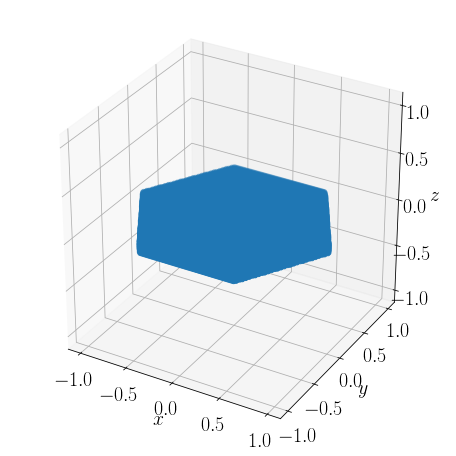

In [6]:
from mpl_toolkits.mplot3d import Axes3D 
from plotting import set_axes_equal
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 20})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=(12, 8))
ax = fig.gca(projection='3d')
ax.set_aspect('equal')

ax.scatter(xd[idx], yd[idx], zd[idx])

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
set_axes_equal(ax)  
plt.show()

# To center-align figure
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Incident field
We consider an incident plane wave, travelling in the positive $x$-direction and polarized in the $z$-direction.

In [7]:
from fields import PlaneWavePointWise
Eo = np.array((0, 0, 1))     # z-polarization
dInc = np.array((1, 0, 0))   # direction
ko = 2*np.pi/lambda_ext
kvec = ko * dInc
Einc = PlaneWavePointWise(Eo, kvec, r)

## Toeplitz operator and its circulant embedding
Here we create the integral operator which, when discretized over a voxel grid, gives rise to a Toeplitz matrix. This Toeplitz matrix is then embedded within a circulant matrix so that the FFT can be employed for matrix-vector products.

In [8]:
from operators import getOPERATOR_DDA
nearby_quad = 'on'  # 'off' reverts to the "classical" DDA, "on" provides more accurate quadrature for nearby voxels
circ_op, Toep, alpha_LDR = getOPERATOR_DDA(r, ko, refInd, kvec, Eo, nearby_quad)

In [9]:
# Establish DDA matrix-vector product function
id = np.ones((L, M, N))   # identity
     
dx = r[1, 0, 0, 0] - r[0, 0, 0, 0]
dV = dx**3;   # voxel volume

In [10]:
Mr = np.ones((L, M, N))
Gram = 1/alpha_LDR
chi = np.zeros((L, M, N), dtype=np.complex128)
chi[idx] = 1; 
Mc = dV * chi

In [11]:
JIn = np.zeros((L, M, N, 3), dtype=np.complex128)
JIn[idx] = Einc[idx]
JInVec = JIn.reshape((3*L*M*N, 1), order='F')

In [12]:
from matvecs import mvp_vec
from scipy.sparse.linalg import LinearOperator
mvp_body = lambda x: mvp_vec(x, circ_op, idx, Gram, Mr, Mc)
A = LinearOperator((3*L*M*N, 3*L*M*N), matvec=mvp_body)

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)


In [13]:
from scipy.sparse.linalg import gmres
import time
# Callback function to output the residual
resvec = []
def residual_vector(rk):
    global resvec
    resvec.append(rk)

start = time.time()
sol, info = gmres(A, JInVec, tol=1e-4, restart=500, callback=residual_vector)
end = time.time()
print("The linear system was solved in {0} iterations".format(len(resvec)))
print('Solve time = ', end-start,'s')
resvec0 = resvec

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)


The linear system was solved in 115 iterations
Solve time =  22.986072063446045 s


In [14]:
Pout = sol.reshape(L, M, N, 3, order='F')
CHI = (refInd**2 - 1) / (4 * np.pi)
Eout = Pout / CHI

Mc = dV * id

idx_n = np.ones((L, M, N, 3), dtype=bool)

mvp_all = lambda x: mvp_vec(x, circ_op, idx_n, Gram, Mr, Mc)

temp = mvp_all(sol)

# Evaluate field throughout computation domain
Etemp = temp.reshape(L, M, N, 3, order='F')
E = Einc - Etemp + Eout;

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)


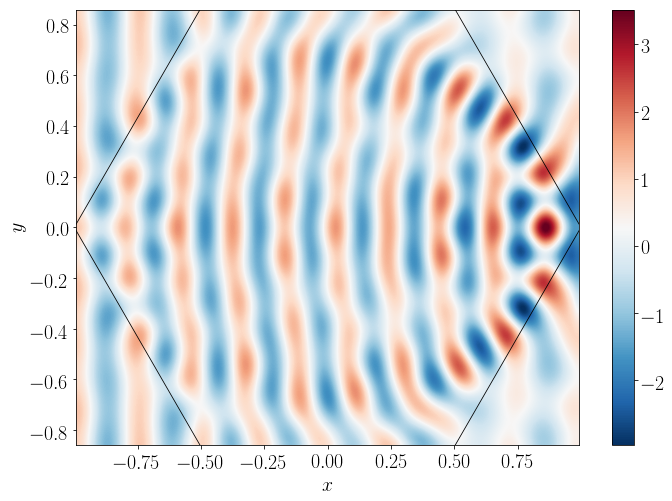

In [15]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
matplotlib.rcParams.update({'font.size': 20})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
plt.imshow(np.real(E[:, :, 1, 2].T), extent=[np.min(xd),np.max(xd),np.min(yd),np.max(yd)],
           cmap=plt.cm.get_cmap('RdBu_r'), interpolation='spline16')

polygon = Polygon(P, facecolor="none", 
              edgecolor='black', lw=0.8)
plt.gca().add_patch(polygon)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar()

plt.show()


## Construct circulant preconditioner

In [16]:
from circulant import circ_1_level
circ, circ_L_opToep = circ_1_level(Toep, L, M, N)

In [17]:
from circulant import circ_2_level
circ2, circ_M_opToep = circ_2_level(circ_L_opToep, L, M, N)

In [18]:
# Invert preconditioner
circ2_inv = np.zeros_like(circ2)
for i in range(0, L):
    for j in range(0, M):
        circ2_inv[i, j, :, :] = np.linalg.inv(1/alpha_LDR*np.identity(3*N) - dV*circ2[i, j, :, :])

In [19]:
from matvecs import mvp_circ2
mvp_prec = lambda x: mvp_circ2(x, circ2_inv, L, M, N, idx)
prec = LinearOperator((3*L*M*N, 3*L*M*N), matvec=mvp_prec)
A = LinearOperator((3*L*M*N, 3*L*M*N), matvec=mvp_body)

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)


In [20]:
start = time.time()
resvec = []
sol1, info1 = gmres(A, JInVec, M=prec, tol=1e-4, restart=500, callback=residual_vector)
end = time.time()
print("The linear system was solved in {0} iterations".format(len(resvec)))
print('Solve time = ', end-start,'s')

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)


The linear system was solved in 27 iterations
Solve time =  7.15099310874939 s


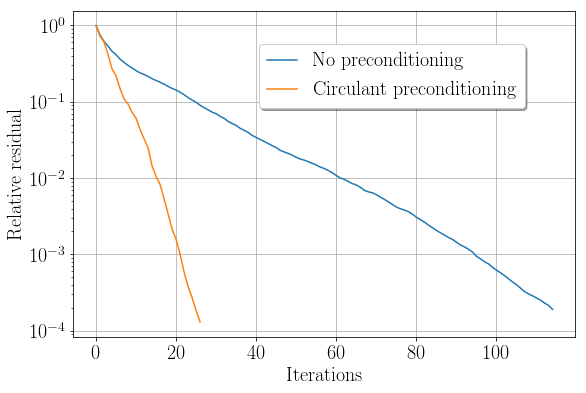

In [21]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams.update({'font.size': 20})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=(9, 6))
ax = fig.gca()
plt.semilogy(resvec0/resvec0[0])
plt.semilogy(resvec/resvec[0])
plt.grid()

# labels
plt.ylabel('Relative residual')
plt.xlabel('Iterations')
# ax.yaxis.major.formatter._useMathText = True

plt.legend(('No preconditioning', 'Circulant preconditioning'),
           shadow=True, loc=(0.37, 0.7), handlelength=1.5, fontsize=20)

In [22]:
np.linalg.norm(mvp_body(sol1)-JInVec)/np.linalg.norm(JInVec)

/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fftn(a, s, axes)


8.703099222243468e-05